In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = '/group/ag_compstatphys/data/tolga/simulation'

In [3]:
obstacle = 'crystalline_walls_W15_rho0.8.h5'

thermalization = 'slit_pore__equilibration_D15_rho0.7_T1.00_20251024_180624.h5'

production_NVE = 'slit_pore__production_D15_rho0.7_T1.00_20251025_155550.h5'
production_NVT = 'slit_pore__production_NVT_D15_rho0.7_T1.00_20251025_203202.h5'


In [4]:
def sample_observables(file_name):

    file_path = f'{data_folder}/{file_name}'

    observables = {}
    num_regions = 0

    with h5py.File(file_path, 'r') as sim_data:
        region_list = list(sim_data['thermo'].keys())
        num_regions = len(region_list)

        # Calculate time averaged stress tensor
        tensor_sampling = np.zeros((num_regions,6))
        for i in range(1, num_regions):
            dataset_path = f'thermo/slab_{i}/stress_tensor/value'
            dataset = sim_data[dataset_path]
            for cur_data in dataset:            
                tensor_sampling[i] += cur_data[0:6]
        tensor_sampling = tensor_sampling/((len(dataset)))
        observables['slab_stress_tensor'] = tensor_sampling


        # Calculate time averaged density 
        density_sampling = np.zeros(num_regions)
        for i in range(1, num_regions):
            dataset_path = f'thermo/slab_{i}/density/value'
            cur_data = sim_data[dataset_path]     
            density_sampling[i] += np.mean(cur_data)
        
        observables['slab_density'] = density_sampling

        stress_tensor = sim_data['observables/stress_tensor/value']
        stress_tensor = np.array(stress_tensor)
        observables['stress_tensor'] = np.mean(stress_tensor, axis = 0)    

        pressure = sim_data['observables/pressure/value']
        pressure = np.array(pressure)
        observables['pressure'] = np.mean(pressure)   

        return observables

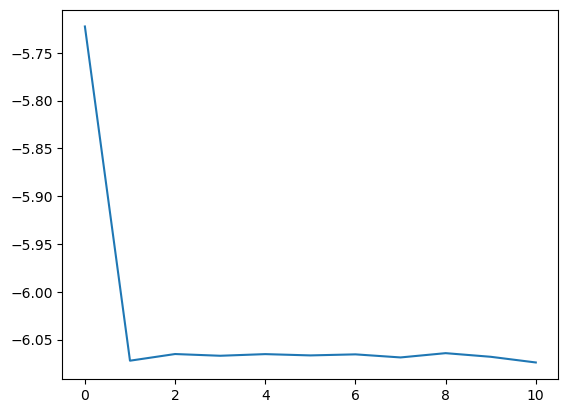

In [5]:
file_path = f'{data_folder}/{thermalization}'
with h5py.File(file_path, 'r') as sim_data:
    potential_energy = np.array(sim_data['observables/potential_energy/value'])
    plt.plot(potential_energy)

plt.show()

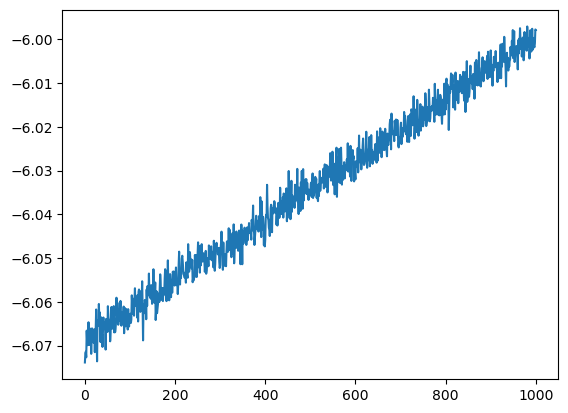

In [6]:
file_path = f'{data_folder}/{production_NVE}'
with h5py.File(file_path, 'r') as sim_data:
    potential_energy = np.array(sim_data['observables/potential_energy/value'])
    plt.plot(potential_energy)

plt.show()

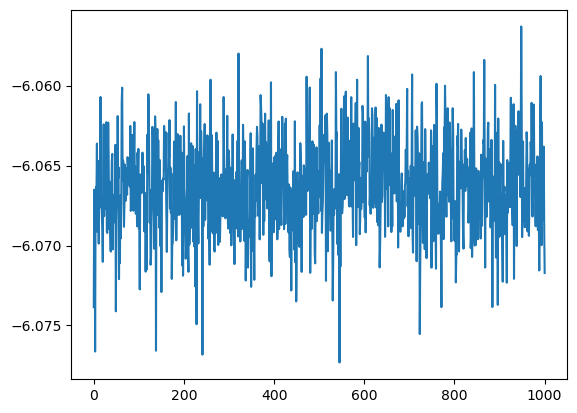

In [7]:
file_path = f'{data_folder}/{production_NVT}'
with h5py.File(file_path, 'r') as sim_data:
    potential_energy = np.array(sim_data['observables/potential_energy/value'])
    plt.plot(potential_energy)

plt.show()

Density profile obtained from individual slabs

In [5]:
observables = sample_observables(production_NVT)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


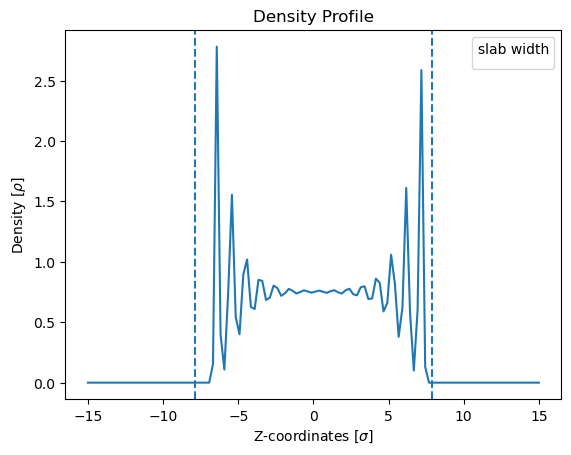

In [9]:
y = observables['slab_density']
x = np.linspace(-15, 15 , y.shape[0])

plt.plot(x,y,)
    

plt.axvline(-7.88, ls = '--')
plt.axvline(7.88, ls = '--')

plt.title("Density Profile")
plt.xlabel(r'Z-coordinates $[\sigma]$')
plt.ylabel(r"Density $[\rho]$")


plt.legend(title = 'slab width')
plt.show()


non-normalized local surface density

$$ \gamma^* = \sigma_\parallel - \sigma_\perp  $$
$$ \gamma^* = \frac{1}{2} (\sigma_{xx} + \sigma_{yy}) - \sigma_{zz} 

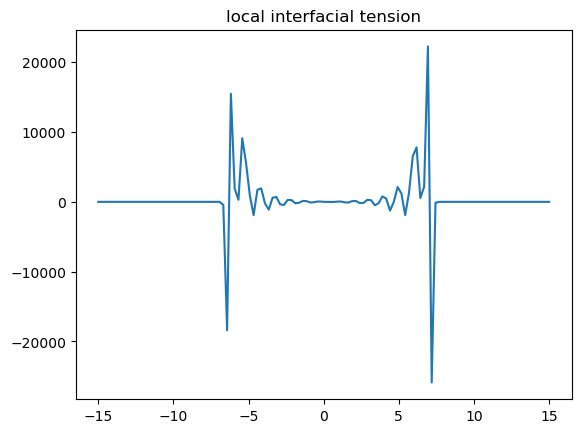

In [10]:
s = []
for i in range(3):
    s.append(observables["slab_stress_tensor"][:,i])

lst = 0.5*(s[0] + s[1]) - s[2]

plt.title("local interfacial tension")
plt.plot(x, lst)

In [11]:
area = 100*100
surface_tension = 0.5 * np.sum(lst)/area
print(f'surface tension per interface: {surface_tension:.3f}') 

surface tension per interface: 1.573


In [31]:
def read_wavevectors(file_name):

    file_path = f'{data_folder}/{file_name}'

    with h5py.File(file_path, 'r') as sim_data:

        # Read wavevectors
        wavenumber_slab_parallel = np.array(sim_data['ssf/slab_1/parallel/wavenumber']).tolist()
        wavenumber_slab_perpendicular = np.array(sim_data['ssf/slab_1/perpendicular/wavenumber']).tolist()

        wavenumber_global_parallel = np.array(sim_data['ssf/global_parallel/bulk/wavenumber']).tolist()
        wavenumber_global_perpendicular = np.array(sim_data['ssf/global_perpendicular/bulk/wavenumber']).tolist()

    return [wavenumber_slab_parallel, wavenumber_slab_perpendicular], [wavenumber_global_parallel, wavenumber_global_perpendicular]



def read_ssf(file_name):

    file_path = f'{data_folder}/{file_name}'
    num_regions = 0

    wavenumber_slab, wavenumber_global = read_wavevectors(file_name)


    with h5py.File(file_path, 'r') as sim_data:
        region_list = list(sim_data['ssf'].keys())
        num_regions = len(region_list)
        num_regions -= 2

        # Calculate time averaged static structure factor
        ssf_parallel = np.zeros((num_regions, len(wavenumber_slab[0]), 3))
        ssf_perpendicular = np.zeros((num_regions, len(wavenumber_slab[1]), 3))

        for i in range(1, num_regions + 1):
            dataset_parallel_path = f'ssf/slab_{i}/parallel/value'
            dataset_perpendicular_path = f'ssf/slab_{i}/perpendicular/value'

            ssf_parallel_cur = np.array(sim_data[dataset_parallel_path])
            ssf_perpendicular_cur = np.array(sim_data[dataset_perpendicular_path])

            ssf_parallel[i-1] = np.average(ssf_parallel_cur, axis = 0)
            ssf_perpendicular[i-1] = np.average(ssf_perpendicular_cur, axis = 0)



        # Calculate time averaged static structure along simulation box
        ssf_parallel_global = np.zeros((len(wavenumber_global[0]), 3))
        ssf_perpendicular_global = np.zeros((len(wavenumber_global[1]), 3))

        dataset_path = f'ssf/global_parallel/bulk/value'
        dataset = sim_data[dataset_path]
        ssf_parallel_global = np.average(np.array(dataset), axis = 0)

        dataset_path = f'ssf/global_perpendicular/bulk/value'
        dataset = sim_data[dataset_path]
        ssf_perpendicular_global = np.average(np.array(dataset), axis = 0)
        

        return ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global
    


In [32]:
file_name = production_NVT

In [33]:
ssf_parallel, ssf_perpendicular, ssf_parallel_global, ssf_perpendicular_global = read_ssf(file_name)
wavenumber_slab, wavenumber_global = read_wavevectors(file_name)

In [34]:
ssf_parallel_global.shape

(238, 3)

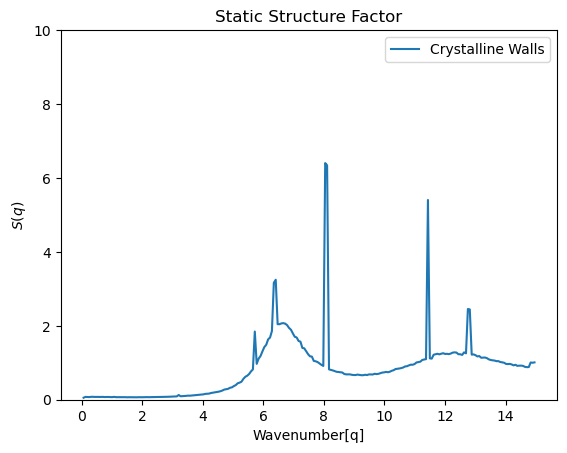

In [35]:

x = wavenumber_global[0]
y = ssf_parallel_global[:, 0]


plt.plot(x, y, label = "Crystalline Walls")

plt.ylim((0,10))

plt.title("Static Structure Factor")
plt.ylabel(r"$S(q)$")
plt.xlabel(r"Wavenumber[q]")
#plt.xscale("log")
plt.legend()
plt.show()

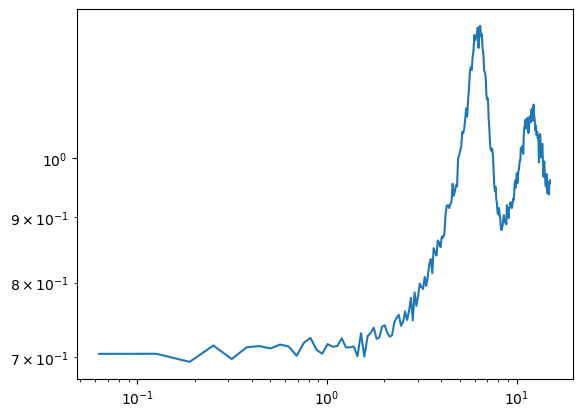

In [36]:
x = wavenumber_slab[0]
y = ssf_parallel[60,:,0] #middle slab

plt.xscale('log')
plt.yscale('log')
plt.plot(x, y)

In [65]:
y.shape

(238,)

OZ FIT Center slabs

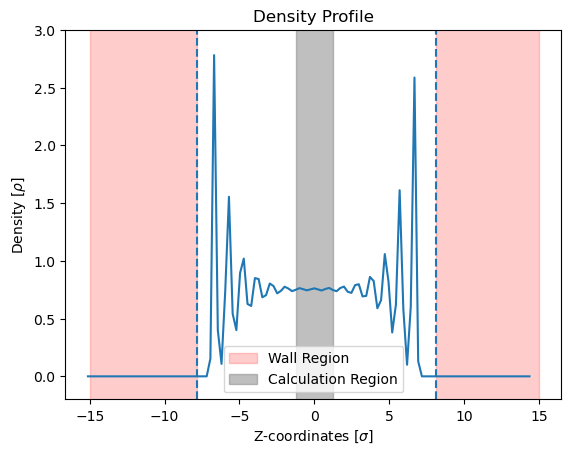

In [37]:
y = observables['slab_density']
x = np.linspace(-15, 14.5 , y.shape[0]) - 0.125

plt.plot(x,y,)
    
plt.axvline(-7.857, ls = '--')
plt.axvline(8.109, ls = '--')

plt.title("Density Profile")
plt.xlabel(r'Z-coordinates $[\sigma]$')
plt.ylabel(r"Density $[\rho]$")


#plt.axvline(-1.25, ls = '--')
#plt.axvline(1.25, ls = '--')

plt.fill_between((-15, -7.857), -5, 5, color='red', alpha=0.2, label = 'Wall Region')
plt.fill_between((8.109, 15), -5, 5, color='red', alpha=0.2)

plt.fill_between((-1.25, 1.25), -5, 5, color='gray', alpha=0.5, label = 'Calculation Region')
plt.legend()
plt.ylim(-0.2, 3)
plt.show()

In [38]:
spatial_sampling = np.zeros(238)

for i in range(10):
    spatial_sampling += ssf_parallel[56+i,:,0]

spatial_sampling /= 10

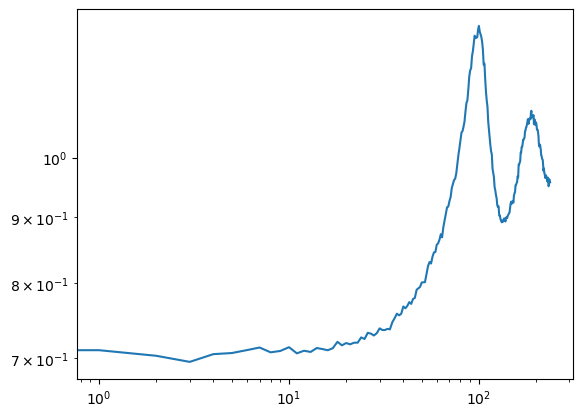

In [39]:
plt.plot(spatial_sampling)
plt.xscale('log')
plt.yscale('log')

In [40]:
from scipy.optimize import curve_fit

def lorentzian(q, s0, xi):

    return s0 / (1 + (q * xi)**2)

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_694683/3249042868.py:38: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  jac[i] = derivative(f, params[i], n=1)
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:2532: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Fitted parameters: a=0.7070±inf, b=-0.0000±inf


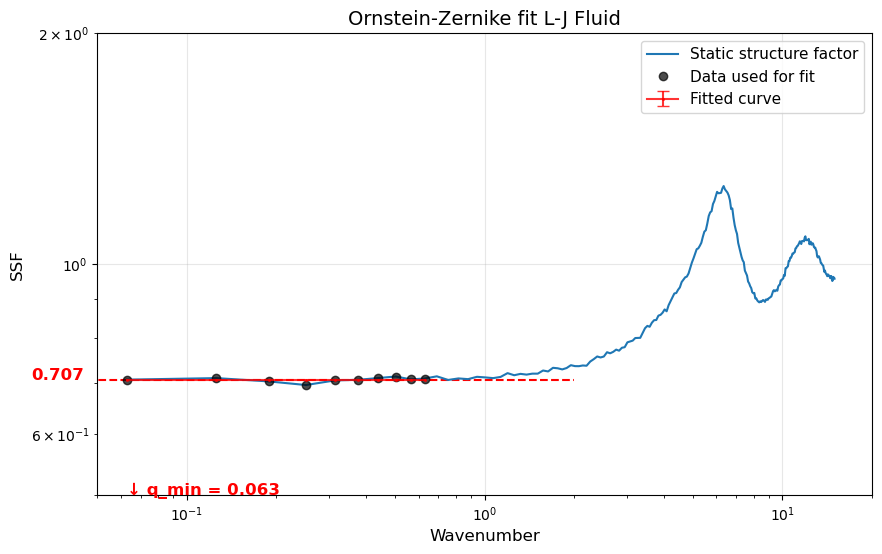

In [41]:
from scipy.misc import derivative

ssf = spatial_sampling
wavenumber = np.array(wavenumber_slab[0])

x_min = 0
x_max = 10

x = wavenumber[x_min:x_max]
y = ssf[x_min:x_max]



popt, pcov = curve_fit(lorentzian, x, y)


plot_range = np.linspace(0, 2, 100)
y_plot_range = lorentzian(plot_range, *popt)

perr = np.sqrt(np.diag(pcov))

print(f"Fitted parameters: a={popt[0]:.4f}±{perr[0]:.4f}, "
      f"b={popt[1]:.4f}±{perr[1]:.4f}")

# Create points for fitted curve (with error bars)
x_fit = np.linspace(x.min(), x.max(), len(x))  
y_fit = lorentzian(x_fit, *popt)

# Calculate Jacobian (partial derivatives) numerically
def jacobian(x_vals, params):
    """Calculate Jacobian matrix: derivatives of model w.r.t. each parameter"""
    jac = np.zeros((len(params), len(x_vals)))
    for i, param in enumerate(params):
        def f(p):
            params_copy = params.copy()
            params_copy[i] = p
            return lorentzian(x_vals, *params_copy)
        jac[i] = derivative(f, params[i], n=1)
    return jac

jac = jacobian(x_fit, popt)

# Error propagation: σ_y = sqrt(sum((∂y/∂p_i * σ_p_i)^2))
y_err = np.sqrt(np.sum((jac * perr[:, np.newaxis])**2, axis=0))

# Plot
plt.figure(figsize=(10, 6))


# Original data
plt.errorbar(x, y, fmt='o', markersize=6, label='Data used for fit', 
             color='black', linestyle='none', capsize=5, alpha=0.7)

# Fitted curve with error bars
plt.errorbar(x_fit, y_fit, yerr=y_err, fmt='s', markersize=1, 
             label='Fitted curve', color='red', linestyle='-', 
             capsize=4, capthick=1, alpha=0.8)

plt.plot(plot_range, y_plot_range, color = 'red', ls = '--')


plt.plot(wavenumber, ssf[:], label = "Static structure factor")



plt.text(0.03, y_plot_range[0], f'{y_plot_range[0]:.3f}',
        fontsize=12, color='red', weight='bold')

plt.text(wavenumber[x_min], 0.5, f'↓ q_min = {wavenumber[x_min]:.3f}',
        fontsize=12, color='red', weight='bold')


plt.ylim(0.5, 2)
plt.xlim(0.05, 20)
plt.xlabel('Wavenumber', fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.ylabel('SSF', fontsize=12)
plt.title('Ornstein-Zernike fit L-J Fluid', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
#plt.tight_layout()
plt.show()

In [42]:
ssf_parallel.shape

(120, 238, 3)

In [43]:
def compressibility_per_slab(ssf_parallel, wavenumber_slab, min_index, max_index):
    local_compressbility = np.zeros(ssf_parallel.shape[0])

    wavenumber = np.array(wavenumber_slab[0])


    #x = wavenumber[min_index:max_index]
    y = ssf[min_index:max_index]
    
    for i in range(ssf_parallel.shape[0]):
        y = ssf_parallel[i, min_index:max_index, 0]
        if not np.isnan(y).any():
            popt, _ = curve_fit(lorentzian, x, y)
            local_compressbility[i] = popt[0]
        
    return local_compressbility

In [44]:
local_compressibility = compressibility_per_slab(ssf_parallel, wavenumber_slab, 0, 10)

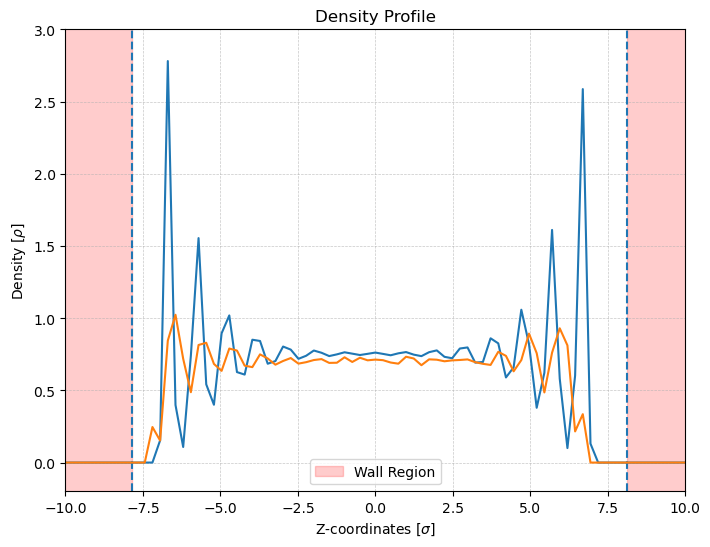

In [45]:
plt.figure(figsize=(8, 6))

y = observables['slab_density']
x = np.linspace(-15, 14.5 , y.shape[0]) - 0.125

plt.plot(x,y,)
    
plt.axvline(-7.857, ls = '--')
plt.axvline(8.109, ls = '--')

plt.title("Density Profile")
plt.xlabel(r'Z-coordinates $[\sigma]$')
plt.ylabel(r"Density $[\rho]$")


#plt.axvline(-1.25, ls = '--')
#plt.axvline(1.25, ls = '--')

plt.fill_between((-15, -7.857), -5, 5, color='red', alpha=0.2, label = 'Wall Region')
plt.fill_between((8.109, 15), -5, 5, color='red', alpha=0.2)

#plt.fill_between((-1.25, 1.25), -5, 5, color='gray', alpha=0.5, label = 'Calculation Region')
plt.legend()
plt.ylim(-0.2, 3)
plt.xlim(-10,10)



plt.plot(x, local_compressibility)





plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()


plt.show()

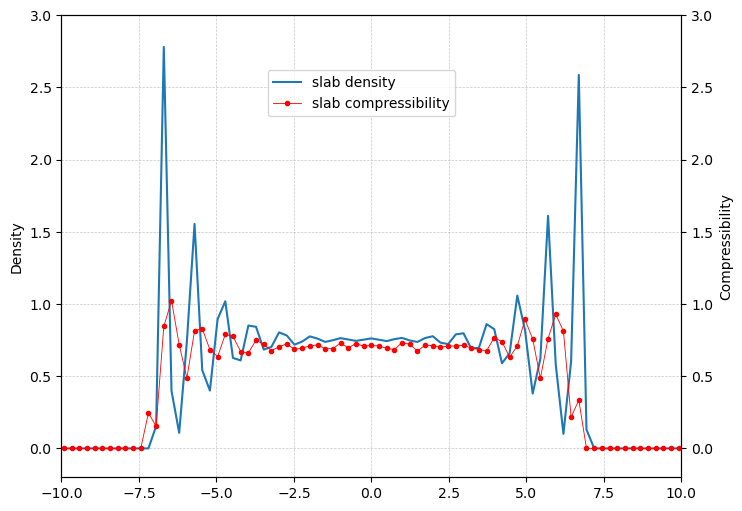

In [46]:
fig, ax1 = plt.subplots(figsize=(8, 6))



y = observables['slab_density']
x = np.linspace(-15, 14.5 , y.shape[0]) - 0.125

ax1.plot(x,y, label = 'slab density')
    
#plt.axvline(-7.857, ls = '--')
#plt.axvline(8.109, ls = '--')


ax2 = ax1.twinx()

ax2.plot(x, local_compressibility, '-o', color = 'red', markersize = 3, linewidth = 0.6, label = 'slab compressibility')



ax1.set_ylabel('Density')
ax2.set_ylabel('Compressibility')

ax1.set_xlim(-10, 10)

ax1.set_ylim(-0.2, 3)
ax2.set_ylim(-0.2, 3)

ax1.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = 9, bbox_to_anchor=(0.5, 0.8))

plt.show()


In [24]:
def read_slab_density_modes(file_name):

    file_path = f'{data_folder}/{file_name}'
    num_regions = 0

    with h5py.File(file_path, 'r') as sim_data:
        region_list = list(sim_data['ssf'].keys())

        num_regions = len(region_list)

        num_regions -= 2

        slab_dm_list = []

        
        for i in range(1, num_regions + 1):
            dataset_parallel_path = f'density_mode/slab_{i}/parallel/value'

            slab_dm_list.append(np.array(sim_data[dataset_parallel_path]))

        

        return np.stack(slab_dm_list)
        

In [25]:
slab_dm_array = read_slab_density_modes(production_NVT)

In [27]:
len(slab_dm_array)

120

In [59]:
N_slab_particles = 1957


ssf_list = []

for _, arr in enumerate(slab_dm_array):

    arr_complex = arr[..., 0] + 1j * arr[..., 1]

    ssf_cur = np.mean(arr_complex * np.conj(arr_complex), axis=0)

    ssf_list.append(ssf_cur)



ssf_array = np.stack(ssf_list)

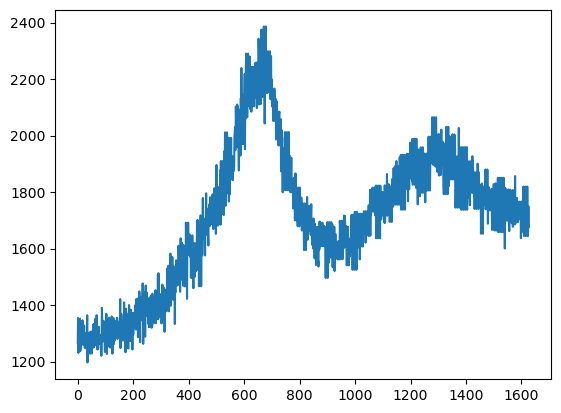

In [58]:
plt.plot(ssf_list[50])

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


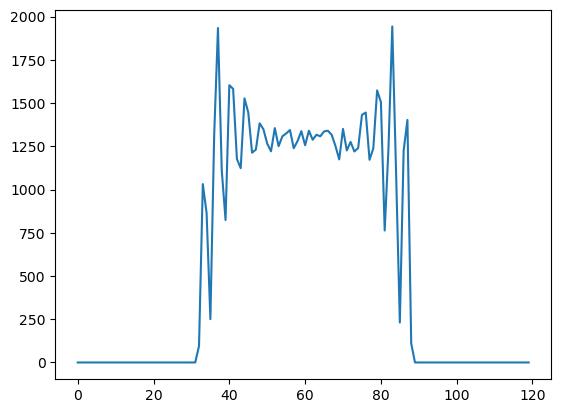

In [ ]:
plt.plot(ssf_array[:,0])

In [63]:
ssf_array.shape

(120, 1627)

In [67]:
ssf_array.shape

(120, 1627)

In [66]:
ssf_parallel.shape

(120, 238, 3)

In [72]:
def compressibility_per_slab_dm(ssf_parallel, wavenumber_slab, min_index, max_index):
    local_compressbility = np.zeros(ssf_parallel.shape[0])

    wavenumber = np.array(wavenumber_slab[0])


    #x = wavenumber[min_index:max_index]
    y = ssf_parallel[min_index:max_index]
    
    for i in range(ssf_parallel.shape[0]):
        y = ssf_parallel[i, min_index:max_index]
        if not np.isnan(y).any():
            popt, _ = curve_fit(lorentzian, x, y)
            local_compressbility[i] = popt[0]
        
    return local_compressbility

In [73]:
wavevector_ms_parallel_path = 'density_mode/slab_60/parallel/wavevector'
file_path = f'{data_folder}/{production_NVT}'
with h5py.File(file_path, 'r') as sim_data:

    wavevectors = np.array(sim_data[wavevector_ms_parallel_path])



In [74]:
wavenumber = np.linalg.norm(wavevectors, axis = 1)

In [71]:
wavenumber.shape

(1627,)

In [75]:
local_compressibility_dm = compressibility_per_slab_dm(ssf_array, wavenumber, 0, 10)

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


ValueError: operands could not be broadcast together with shapes (120,) (10,) 